In [8]:
import numpy as np
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    InverseDynamicsController,
    MeshcatVisualizer,
    MultibodyPlant,
    Parser,
    Simulator,
    StartMeshcat,
    HalfSpace,
    CoulombFriction,
    PidController,
    LeafSystem, 
    BasicVector,
    LogVectorOutput
)
import numpy as np

In [2]:
# Start the visualizer.
meshcat = StartMeshcat()

Installing NginX server for MeshCat on Deepnote...
INFO:drake:Meshcat listening for connections at https://c140ec4a-6224-46c8-b55a-d8a7a25ad3a5.deepnoteproject.com/7000/


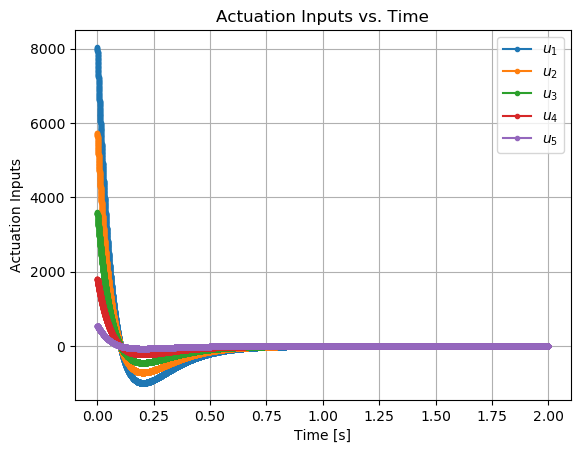

In [11]:
import matplotlib.pyplot as plt

def animation_demo():
    builder = DiagramBuilder()

    # Adds both MultibodyPlant and the SceneGraph, and wires them together.
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
    # Note that we parse into both the plant and the scene_graph here.
    pendulum_model = Parser(plant, scene_graph).AddModels("five_link.urdf")[0]
    # plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("base"))
    plant.Finalize()

    # Adds the MeshcatVisualizer and wires it to the SceneGraph.
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    kp = [100] * plant.num_positions()
    ki = [1] * plant.num_positions()
    kd = [20] * plant.num_positions()
    pendulum_controller = builder.AddSystem(InverseDynamicsController(plant, kp, ki, kd, False))
    pendulum_controller.set_name("pendulum_controller")
    builder.Connect(
        plant.get_state_output_port(pendulum_model),
        pendulum_controller.get_input_port_estimated_state(),
    )
    builder.Connect(
        pendulum_controller.get_output_port_control(), plant.get_actuation_input_port()
    )

    logger = LogVectorOutput(pendulum_controller.get_output_port_control(), builder)
    logger.set_name("logger")

    diagram = builder.Build()
    diagram.set_name("with pendulum controller")

    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyMutableContextFromRoot(context)
    q0 = np.array([0, 0, 0, 0, 0])
    x0 = np.hstack(([3.14, 0, 0, 0, 0], 0 * q0))
    plant.SetPositions(plant_context, q0)
    pendulum_controller.GetInputPort("desired_state").FixValue(
        pendulum_controller.GetMyMutableContextFromRoot(context), x0
    )

    logger.FindMutableLog(context).Clear()

    simulator = Simulator(diagram, context)
    simulator.set_target_realtime_rate(1.0)

    meshcat.StartRecording()
    simulator.AdvanceTo(2.0)
    meshcat.StopRecording()
    meshcat.PublishRecording()

    # Grab results from Logger:
    log = logger.FindLog(simulator.get_context())
    time = log.sample_times()
    data = log.data().transpose()

    # Plot the Results:
    plt.figure()
    # Plot each element of the data with a unique legend.
    for i in range(data.shape[1]):
        plt.plot(time, data[:, i], '.-', label=f"$u_{i + 1}$")

    # Add legend, labels, and title
    plt.xlabel("Time [s]")
    plt.ylabel("Actuation Inputs")
    plt.legend()  # Show legend for each input
    plt.title("Actuation Inputs vs. Time")
    plt.grid()
    plt.show()


animation_demo()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c140ec4a-6224-46c8-b55a-d8a7a25ad3a5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>